# Este codigo ya cumplió su cometido de agregarle las precipitaciones bien y faltantes a los datos con -200 faltantes

In [2]:
#Poniendole la suma de precipitaciones a los datos de entrenamiento:
import pandas as pd

df = pd.read_csv('df_200_con_huecos.csv', index_col=0)
df


,date,rio_id,lat,lon,altura_value,precipitaciones_value
0,2023-01-01,10-10,-25.916679,-54.621134,7.80,0.0
1,2023-01-02,10-10,-25.916679,-54.621134,6.50,38.5
2,2023-01-03,10-10,-25.916679,-54.621134,7.20,22.3
3,2023-01-04,10-10,-25.916679,-54.621134,7.10,1.3
4,2023-01-05,10-10,-25.916679,-54.621134,8.10,0.0
...,...,...,...,...,...,...
190696,2025-10-01,99-99,-33.014444,-58.504167,2.06,0.0
190697,2025-10-02,99-99,-33.014444,-58.504167,2.06,0.0
190698,2025-10-03,99-99,-33.014444,-58.504167,2.00,0.0
190699,2025-10-04,99-99,-33.014444,-58.504167,1.98,0.1


## Iniciando request a Open Meteo para corregir el nro de precipitaciones.

In [3]:
def tomar_precipitaciones_bien(lat, lon):
    """Devuelve una lista 'precipitation_sum' con valores diarios desde 2023-01-01 hasta 2025-10-05.
    Si faltan días se rellenan con 0 manteniendo la posición correspondiente."""
    import requests
    import pandas as pd
    start = pd.Timestamp('2023-01-01')
    end = pd.Timestamp('2025-10-05')
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}"
        f"&start_date={start.date()}&end_date={end.date()}&daily=precipitation_sum&timezone=auto"
    )
    try:
        resp = requests.get(url, timeout=20)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print('Error al obtener datos de la API:', e)
        precipitation_sum = []
        return precipitation_sum

    daily = data.get('daily', {})
    times = daily.get('time', [])
    precs = daily.get('precipitation_sum', [])

    # Crear serie datetime -> precipitación (maneja desajustes de longitud)
    try:
        # Truncar al tamaño mínimo entre times y precs si es necesario
        n = min(len(times), len(precs))
        times_trunc = times[:n]
        precs_trunc = precs[:n]
        idx = pd.to_datetime(times_trunc, errors='coerce')
        ser = pd.Series(data=precs_trunc, index=idx)
    except Exception as e:
        print('Error al parsear arrays de daily:', e)
        ser = pd.Series(dtype=float)

    # Rango completo de fechas y reindexar rellenando con 0 donde falte
    full_index = pd.date_range(start, end, freq='D')
    ser = ser.reindex(full_index, fill_value=0)

    # Asegurar que el resultado es una lista de floats/ints con la longitud esperada
    precipitation_sum = [float(x) if pd.notna(x) else 0.0 for x in ser.tolist()]
    return precipitation_sum


In [4]:
def crear_serie_precipitaciones(arr, start='2023-01-01', col_name='precipitaciones_value'):
    """Crear DataFrame diario con columna col_name a partir de un iterable `arr`.
    - start: fecha inicial (string o datetime).
    - Si arr está vacío devuelve DataFrame vacío con la columna requerida.
    """
    import pandas as pd
    # Normalizar None/NaN y convertir a lista
    if arr is None:
        return pd.DataFrame(columns=[col_name])
    if isinstance(arr, pd.Series):
        values = arr.fillna(0).tolist()
    else:
        try:
            # evitar tratar strings como iterables de caracteres
            if isinstance(arr, (str, bytes)):
                values = [arr]
            else:
                values = [0.0 if (x is None or (isinstance(x, float) and pd.isna(x))) else x for x in arr]
        except TypeError:
            values = [arr]

    # asegurar tipos numéricos y reemplazar NaN/None por 0.0
    cleaned = []
    for v in values:
        try:
            if v is None:
                cleaned.append(0.0)
            else:
                # convertir a float si posible
                cleaned.append(float(v))
        except Exception:
            cleaned.append(0.0)

    n = len(cleaned)
    if n == 0:
        return pd.DataFrame(columns=[col_name])

    start_ts = pd.to_datetime(start)
    idx = pd.date_range(start=start_ts, periods=n, freq='D')
    df = pd.DataFrame({col_name: cleaned}, index=idx)
    # opcional: asegurar nombre del índice
    df.index.name = 'date'
    return df


In [ ]:
import pandas as pd
from tqdm import tqdm  # solo para ver progreso visual

df = df.copy()

# Crear una columna vacía donde se van a colocar las precipitaciones
df.drop(columns="precipitaciones_value")
df["precipitaciones_value"] = None

# Iterar por cada rio_id único
for rio_id in tqdm(df["rio_id"].unique(), desc="Procesando ríos"):
    # Filtrar datos de ese río
    df_rio_mask = df["rio_id"] == rio_id
    df_rio = df[df_rio_mask]
    
    # Obtener lat/lon únicos de ese río
    lat = df_rio["lat"].iloc[0]
    lon = df_rio["lon"].iloc[0]
    
    # Llamar a la función que obtiene las precipitaciones
    arr_precip = tomar_precipitaciones_bien(lat, lon)
    
    # Crear DataFrame diario con la serie de precipitaciones
    df_precip = crear_serie_precipitaciones(arr_precip, start="2023-01-01", col_name="precipitaciones_value")
    
    # Asegurar que coincidan las longitudes
    if len(df_precip) != len(df_rio):
        print(f"⚠️ Longitud distinta en río {rio_id}: {len(df_precip)} vs {len(df_rio)}. Rellenando o recortando.")
        df_precip = df_precip.iloc[:len(df_rio)].reindex(range(len(df_rio))).fillna(0)
    
    # Asignar la columna al DataFrame original
    df.loc[df_rio_mask, "precipitaciones_value"] = df_precip["precipitaciones_value"].values

print("✅ Precipitaciones integradas correctamente en el DataFrame.")


Procesando ríos: 100%|██████████| 189/189 [03:56<00:00,  1.25s/it]

✅ Precipitaciones integradas correctamente en el DataFrame.


In [12]:
import pandas as pd
from tqdm import tqdm  # barra de progreso

# Hacemos una copia del df original por seguridad
df = df.copy()

# 1️⃣ Eliminamos la vieja columna precipitaciones_value
if "precipitaciones_value" in df.columns:
    df = df.drop(columns=["precipitaciones_value"])

# 2️⃣ Creamos la nueva columna vacía
df["precipitaciones_value"] = None

# 3️⃣ Iteramos por cada rio_id único
for rio_id in tqdm(df["rio_id"].unique(), desc="Actualizando precipitaciones por río"):
    # Filtramos las filas correspondientes a ese río
    mask = df["rio_id"] == rio_id
    df_rio = df.loc[mask]

    # Obtenemos lat y lon (únicos por río)
    lat = df_rio["lat"].iloc[0]
    lon = df_rio["lon"].iloc[0]

    # 🔹 Llamamos a la API para obtener las precipitaciones de ese punto
    arr_precip = tomar_precipitaciones_bien(lat, lon)

    # 🔹 Convertimos esa lista en un DataFrame con fechas
    df_precip = crear_serie_precipitaciones(arr_precip, start="2023-01-01")

    # 🔹 Ahora emparejamos por fecha (suponiendo que df tiene una columna 'fecha' o similar)
    if "fecha" in df_rio.columns:
        df_rio = df_rio.sort_values("fecha")
        df_precip = df_precip.reset_index().rename(columns={"date": "fecha"})
        df_precip["fecha"] = pd.to_datetime(df_precip["fecha"])
        df_rio["fecha"] = pd.to_datetime(df_rio["fecha"])

        # Hacemos un merge por fecha para asignar correctamente
        df_merged = pd.merge(
            df_rio.drop(columns=["precipitaciones_value"], errors="ignore"),
            df_precip,
            on="fecha",
            how="left"
        )

        # Actualizamos los valores en el df original
        df.loc[mask, "precipitaciones_value"] = df_merged["precipitaciones_value"].values
    else:
        # Si no hay columna de fecha, simplemente asignamos por orden
        n = min(len(df_rio), len(arr_precip))
        df.loc[mask, "precipitaciones_value"] = arr_precip[:n]

print("✅ Precipitaciones reales integradas correctamente.")


Actualizando precipitaciones por río: 100%|██████████| 189/189 [04:08<00:00,  1.31s/it]

✅ Precipitaciones reales integradas correctamente.


In [13]:
df.groupby("rio_id")["precipitaciones_value"].apply(lambda x: x.isna().sum())


rio_id
10-10        0
11-11        0
12-12        0
13-13        0
14-14        0
            ..
9412-2837    0
9494-2844    0
9542-2813    0
9549-2809    0
99-99        0
Name: precipitaciones_value, Length: 189, dtype: int64

In [18]:
df.to_csv("df_200_con_huecos.csv")

In [19]:
df.groupby("rio_id")["altura_value"].apply(lambda x: x.isna().sum())


rio_id
10-10         14
11-11         14
12-12         14
13-13         14
14-14         14
            ... 
9412-2837    148
9494-2844    190
9542-2813     14
9549-2809     54
99-99         14
Name: altura_value, Length: 189, dtype: int64

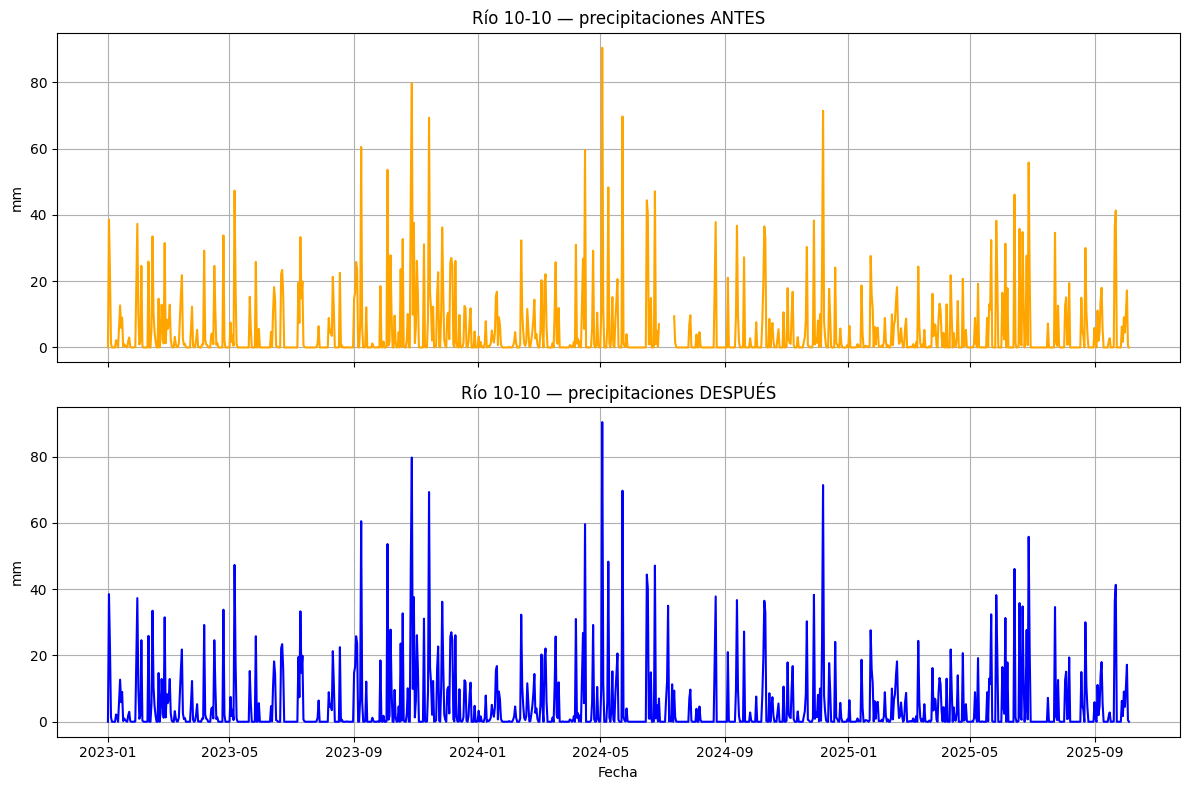

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

axes[0].plot(df_viejo["date"], df_viejo["precipitaciones_value"], color='orange')
axes[0].set_title(f"Río {rio_ejemplo} — precipitaciones ANTES")
axes[0].set_ylabel("mm")

axes[1].plot(df_nuevo["date"], df_nuevo["precipitaciones_value"], color='blue')
axes[1].set_title(f"Río {rio_ejemplo} — precipitaciones DESPUÉS")
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("mm")

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()
